In [ ]:
from transformers import AutoTokenizer, EsmModel
import torch
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

In [ ]:
data_path = "/path/to/data/"
sequences_path = Path("/path/to/sequences/")
car_embedding_path = "/path/to/car/embedding"

In [2]:
adata = sc.read_h5ad(f"{data_path}/20240229_from_rocio_for_manuscript.h5ad")
adata

AnnData object with n_obs × n_vars = 58949 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'CAR_Variant', 'Donor', 'Time', 'Lane', 'Sample', 'percent.mt', 'A', 'B', 'C', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.75', 'seurat_clusters', 'subset_RNA', 'subset_ADT', 'subset', 'Cytotoxicity_1', 'Proinflamatory_2', 'Memory_3', 'CD4_Th1_4', 'CD4_Th2_5', 'ident'
    obsm: 'HARMONY', 'X_pca', 'X_umap'
    layers: 'logcounts'

In [3]:
domains = ["CD28", "41BB", "CTLA4", "IL15RA", "CD40", "z", 
           "domain_to_domain", "domain_to_z", "extracell_and_TMD_CARs", "NANANA_tiny_tail"]
linker_AA = "SA"
all_domains = {}
for d in domains:
    with open(sequences_path /  f"{d}.txt") as f:
        lines = f.readlines()
        lines = "".join(lines)
        all_domains[d] = lines
        print(d, len(lines))
all_domains["NA"] = ""

CD28 41
41BB 42
CTLA4 41
IL15RA 39
CD40 62
z 113
domain_to_domain 2
domain_to_z 2
extracell_and_TMD_CARs 342
NANANA_tiny_tail 2


In [4]:
all_domains

{'CD28': 'RSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRS',
 '41BB': 'KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCEL',
 'CTLA4': 'AVSLSKMLKKRSPLTTGVYVKMPPTEPECEKQFQPYFIPIN',
 'IL15RA': 'KSRQTPPLASVEMEAMEALPVTWGTSSRDEDLENCSHHL',
 'CD40': 'KKVAKKPTNKAPHPKQEPQEINFPDDLPGSNTAAPVQETLHGCQPVTQEDGKESRISVQERQ',
 'z': 'RVKFSRSADAPAYQQGQNQLYNELNLGRREEYDVLDKRRGRDPEMGGKPQRRKNPQEGLYNELQKDKMAEAYSEIGMKGERRRGKGHDGLYQGLSTATKDTYDALHMQALPPR',
 'domain_to_domain': 'SA',
 'domain_to_z': 'AS',
 'extracell_and_TMD_CARs': 'DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIKRTGSTSGSGKPGSGEGSEVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDVWGQGTLVTVSSSANWSHPQFEKGGGGSGGGGSNWSHPQFEKSAIEVMYPPPYLDNEKSNGTIIHVKGKHLCPSPLFPGPSKPFWVLVVVGGVLACYSLLVTVAFIIFWV',
 'NANANA_tiny_tail': 'RS',
 'NA': ''}

In [5]:
all_cars = adata.obs["CAR_Variant"].unique().tolist()

In [6]:
full_cars = {}
tails = {}
for car in all_cars:
    domain1, domain2, domain3 = car.split("-")
    if domain3 == "NA":
        tail = all_domains["NANANA_tiny_tail"]
    else:
        tail = all_domains[domain1] + all_domains[domain2] + all_domains[domain3]
    full_car = all_domains["extracell_and_TMD_CARs"] + tail
    full_cars[car] = full_car
    tails[car] = tail

In [7]:
seqs = pd.DataFrame(pd.Series(full_cars).rename("full_car")).merge(pd.Series(tails).rename("tail"),
                                                           left_index=True, right_index=True)
seqs

,full_car,tail
41BB-41BB-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELKRGR...
41BB-CD28-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELRSKR...
41BB-CD40-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELKKVA...
41BB-CTLA4-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELAVSL...
41BB-IL15RA-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELKSRQ...
41BB-NA-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,KRGRKKLLYIFKQPFMRPVQTTQEEDGCSCRFPEEEEGGCELRVKF...
CD28-41BB-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,RSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRSKRGRK...
CD28-CD28-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,RSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRSRSKRS...
CD28-CD40-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,RSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRSKKVAK...
CD28-CTLA4-z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,RSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRSAVSLS...


# Small ESM

In [8]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

inputs = tokenizer(seqs["full_car"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
last_hidden_states.shape

torch.Size([32, 581, 320])

In [10]:
avg_embed_seq = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim = last_hidden_states.numpy().mean(axis=1)


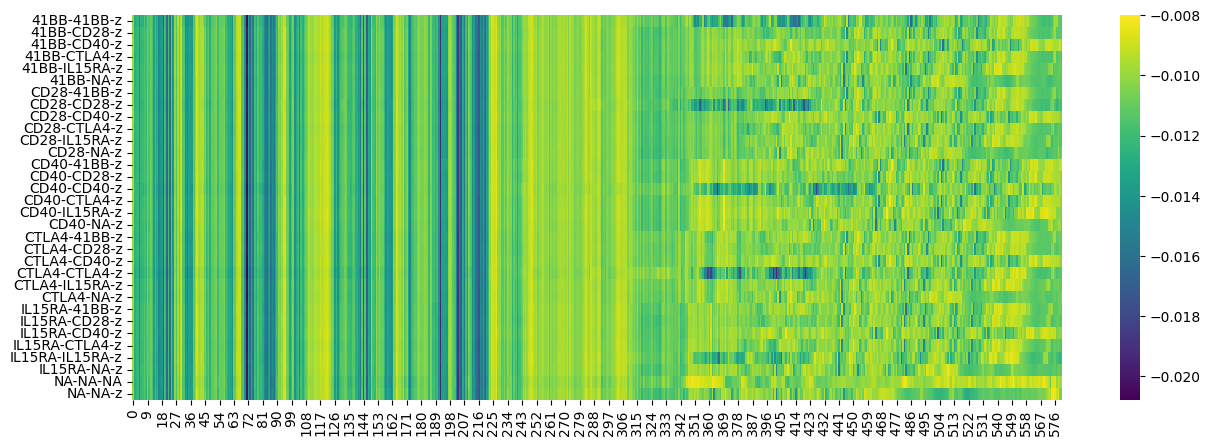

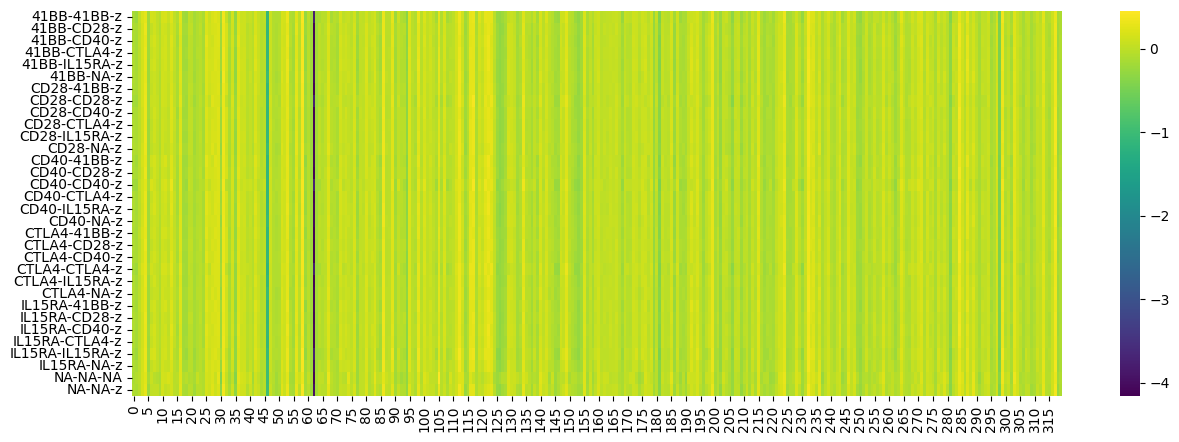

In [11]:
plt.figure(figsize=(15,5))
sns.heatmap(avg_embed_seq, yticklabels=seqs.index, cmap="viridis")
plt.show()

plt.figure(figsize=(15,5))
sns.heatmap(avg_embed_dim, yticklabels=seqs.index, cmap="viridis")
plt.show()

In [12]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

inputs = tokenizer(seqs["tail"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
avg_embed_seq_tail = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim_tail = last_hidden_states.numpy().mean(axis=1)


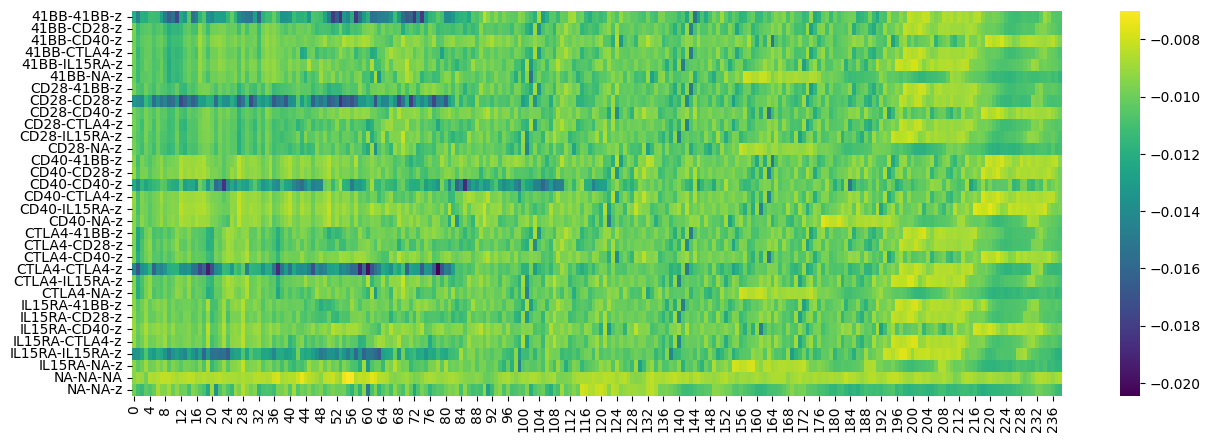

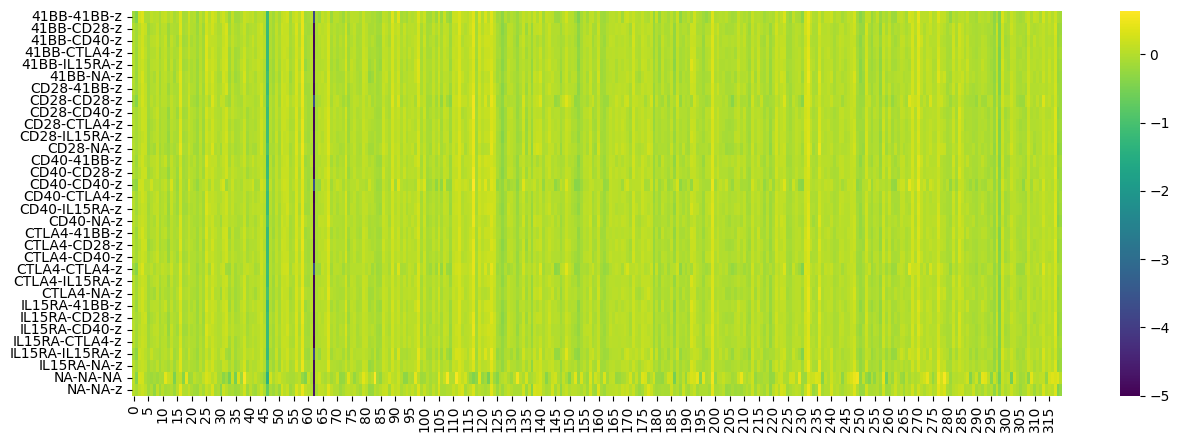

In [14]:
plt.figure(figsize=(15,5))
sns.heatmap(avg_embed_seq_tail, yticklabels=seqs.index, cmap="viridis")
plt.show()

plt.figure(figsize=(15,5))
sns.heatmap(avg_embed_dim_tail, yticklabels=seqs.index, cmap="viridis")
plt.show()

In [15]:
full_car_avg_seq = pd.DataFrame(avg_embed_seq, index=seqs.index).T
full_car_avg_dim = pd.DataFrame(avg_embed_dim, index=seqs.index).T

tail_avg_seq = pd.DataFrame(avg_embed_seq_tail, index=seqs.index).T
tail_avg_dim = pd.DataFrame(avg_embed_dim_tail, index=seqs.index).T

In [16]:
tail_avg_seq

,41BB-41BB-z,41BB-CD28-z,41BB-CD40-z,41BB-CTLA4-z,41BB-IL15RA-z,41BB-NA-z,CD28-41BB-z,CD28-CD28-z,CD28-CD40-z,CD28-CTLA4-z,...,CTLA4-IL15RA-z,CTLA4-NA-z,IL15RA-41BB-z,IL15RA-CD28-z,IL15RA-CD40-z,IL15RA-CTLA4-z,IL15RA-IL15RA-z,IL15RA-NA-z,NA-NA-NA,NA-NA-z
0,-0.012112,-0.009677,-0.009838,-0.009686,-0.009871,-0.009959,-0.009755,-0.013285,-0.009858,-0.009740,...,-0.009484,-0.009438,-0.009276,-0.009186,-0.008986,-0.009131,-0.013509,-0.009371,-0.009368,-0.009915
1,-0.014421,-0.011364,-0.011064,-0.011511,-0.011286,-0.011402,-0.010753,-0.013819,-0.010330,-0.010464,...,-0.011993,-0.012233,-0.010675,-0.010385,-0.010164,-0.010333,-0.013421,-0.010335,-0.008959,-0.011035
2,-0.011933,-0.010654,-0.010431,-0.010677,-0.010719,-0.010566,-0.010975,-0.014111,-0.010695,-0.011245,...,-0.010876,-0.011017,-0.009933,-0.010100,-0.009609,-0.009922,-0.012411,-0.009974,-0.009066,-0.011447
3,-0.012084,-0.010481,-0.010174,-0.010187,-0.010007,-0.010388,-0.009991,-0.011403,-0.009776,-0.009829,...,-0.009805,-0.009807,-0.009227,-0.009163,-0.008760,-0.009048,-0.010691,-0.008963,-0.009843,-0.010324
4,-0.011165,-0.010321,-0.010060,-0.010143,-0.010154,-0.010220,-0.010537,-0.012282,-0.010255,-0.010142,...,-0.009170,-0.009132,-0.010231,-0.010246,-0.009592,-0.009956,-0.012594,-0.009991,-0.008620,-0.010729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,-0.009022,-0.009615,-0.008981,-0.009331,-0.009845,-0.011032,-0.010378,-0.010585,-0.008891,-0.010151,...,-0.010407,-0.010842,-0.010400,-0.010581,-0.009187,-0.010362,-0.010966,-0.010834,-0.008643,-0.010297
235,-0.009598,-0.010077,-0.008700,-0.010096,-0.010093,-0.010879,-0.010456,-0.010890,-0.008635,-0.010221,...,-0.010489,-0.011182,-0.010497,-0.010703,-0.009505,-0.010639,-0.011019,-0.011455,-0.008878,-0.010351
236,-0.010513,-0.010269,-0.008415,-0.010190,-0.010172,-0.011202,-0.010277,-0.010962,-0.009117,-0.010394,...,-0.010328,-0.010955,-0.010701,-0.010580,-0.009973,-0.010445,-0.011431,-0.011343,-0.009155,-0.010734
237,-0.010672,-0.010542,-0.009129,-0.010406,-0.010280,-0.010975,-0.010512,-0.010915,-0.009459,-0.010672,...,-0.010629,-0.011471,-0.010386,-0.010803,-0.010128,-0.010635,-0.011783,-0.011631,-0.008826,-0.011272


In [21]:
# full_car_avg_seq.to_csv(f"{car_embedding_path}esm_small_full_seq")
# full_car_avg_dim.to_csv(f"{car_embedding_path}esm_small_full_dim")
# tail_avg_seq.to_csv(f"{car_embedding_path}esm_small_tail_seq")
# tail_avg_dim.to_csv(f"{car_embedding_path}esm_small_tail_dim")

In [21]:
full_car_avg_seq

,41BB-41BB-z,41BB-CD28-z,41BB-CD40-z,41BB-CTLA4-z,41BB-IL15RA-z,41BB-NA-z,CD28-41BB-z,CD28-CD28-z,CD28-CD40-z,CD28-CTLA4-z,...,CTLA4-IL15RA-z,CTLA4-NA-z,IL15RA-41BB-z,IL15RA-CD28-z,IL15RA-CD40-z,IL15RA-CTLA4-z,IL15RA-IL15RA-z,IL15RA-NA-z,NA-NA-NA,NA-NA-z
0,-0.009999,-0.009954,-0.009740,-0.009849,-0.009882,-0.009885,-0.009963,-0.009931,-0.009748,-0.009845,...,-0.009889,-0.009930,-0.009814,-0.009830,-0.009760,-0.009713,-0.009727,-0.009805,-0.010266,-0.009759
1,-0.012795,-0.012494,-0.012383,-0.012691,-0.012638,-0.012632,-0.012516,-0.012475,-0.012310,-0.012517,...,-0.012708,-0.012719,-0.012800,-0.012633,-0.012646,-0.012757,-0.012857,-0.012792,-0.012703,-0.012640
2,-0.012490,-0.012421,-0.012423,-0.012383,-0.012412,-0.012477,-0.012432,-0.012521,-0.012403,-0.012417,...,-0.012432,-0.012519,-0.012242,-0.012267,-0.012214,-0.012206,-0.012156,-0.012246,-0.012494,-0.012354
3,-0.012460,-0.012042,-0.012149,-0.012220,-0.012170,-0.012211,-0.012108,-0.012109,-0.012061,-0.012074,...,-0.012233,-0.012305,-0.012245,-0.012104,-0.012165,-0.012260,-0.012268,-0.012213,-0.012204,-0.012130
4,-0.014465,-0.014238,-0.014186,-0.014377,-0.014238,-0.014306,-0.014358,-0.014448,-0.014320,-0.014447,...,-0.014451,-0.014522,-0.014142,-0.014127,-0.014129,-0.014195,-0.014055,-0.014095,-0.014003,-0.014238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,-0.009805,-0.009913,-0.009570,-0.009639,-0.011137,-0.011389,-0.009980,-0.011646,-0.009538,-0.011676,...,-0.010895,-0.011006,-0.011202,-0.011332,-0.009114,-0.011054,-0.011085,-0.011083,-0.008617,-0.008364
577,-0.009749,-0.011292,-0.009584,-0.011519,-0.011237,-0.011165,-0.011583,-0.012416,-0.009713,-0.011572,...,-0.010971,-0.011338,-0.011283,-0.010980,-0.010570,-0.011221,-0.011829,-0.011432,-0.010050,-0.009056
578,-0.011143,-0.011412,-0.009557,-0.011249,-0.010983,-0.011044,-0.011207,-0.011859,-0.009461,-0.011112,...,-0.010574,-0.010684,-0.010921,-0.010907,-0.010259,-0.010870,-0.012062,-0.010753,-0.009439,-0.008813
579,-0.011191,-0.011264,-0.009011,-0.011122,-0.010956,-0.011344,-0.011128,-0.011630,-0.010256,-0.011274,...,-0.011126,-0.011042,-0.010838,-0.011391,-0.010222,-0.011364,-0.012353,-0.011262,-0.009814,-0.010496


In [18]:
tail_avg_dim

,41BB-41BB-z,41BB-CD28-z,41BB-CD40-z,41BB-CTLA4-z,41BB-IL15RA-z,41BB-NA-z,CD28-41BB-z,CD28-CD28-z,CD28-CD40-z,CD28-CTLA4-z,...,CTLA4-IL15RA-z,CTLA4-NA-z,IL15RA-41BB-z,IL15RA-CD28-z,IL15RA-CD40-z,IL15RA-CTLA4-z,IL15RA-IL15RA-z,IL15RA-NA-z,NA-NA-NA,NA-NA-z
0,-0.159248,-0.018250,-0.007286,-0.000473,0.004082,0.017143,-0.010079,-0.155021,-0.010296,0.004394,...,0.038025,0.049377,0.007927,0.007262,0.036179,0.036606,-0.123351,0.042819,0.080127,0.029547
1,-0.426648,-0.161065,-0.173219,-0.208297,-0.221836,-0.234092,-0.179206,-0.385847,-0.116938,-0.133985,...,-0.173187,-0.144655,-0.225739,-0.133335,-0.145140,-0.177785,-0.341004,-0.175544,-0.416237,-0.100323
2,0.228566,0.033252,0.097908,0.104843,0.092737,0.105835,0.051474,0.078987,0.031602,0.037655,...,0.074786,0.088822,0.094652,-0.009092,0.057498,0.075651,0.181425,0.087503,0.274247,0.096793
3,0.330889,0.227912,0.220669,0.258766,0.191968,0.267804,0.235665,0.256392,0.181746,0.189541,...,0.159983,0.221321,0.204052,0.153618,0.135540,0.172978,0.147235,0.148536,0.258072,0.182983
4,-0.057816,0.143965,0.036044,0.067683,0.055514,0.025435,0.116468,0.126558,0.156635,0.168516,...,0.121444,0.098423,0.050512,0.195934,0.106032,0.125730,0.041843,0.075958,-0.047634,0.069254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.142514,0.076639,0.013769,0.085644,0.132265,0.150358,0.066180,0.129989,-0.010233,0.063575,...,0.101882,0.114081,0.115989,0.098273,0.034222,0.090926,0.148735,0.150091,0.262384,0.126119
316,-0.003592,0.011726,-0.002595,-0.001908,-0.015344,0.009529,0.029061,-0.042038,0.024619,0.044250,...,0.004992,0.033800,-0.003999,0.007262,0.009368,0.009598,-0.043991,0.028311,0.366872,0.056765
317,0.180677,0.276116,0.222953,0.197672,0.232296,0.231046,0.245309,0.235934,0.341695,0.318200,...,0.294234,0.296589,0.209718,0.334575,0.337098,0.272729,0.216317,0.321346,0.301222,0.338588
318,-0.089475,-0.244118,-0.245185,-0.183046,-0.225289,-0.257617,-0.201505,-0.170215,-0.289884,-0.234683,...,-0.229402,-0.291871,-0.203140,-0.272498,-0.317709,-0.206897,-0.184408,-0.328964,0.357609,-0.429516


In [19]:
tail_avg_seq

,41BB-41BB-z,41BB-CD28-z,41BB-CD40-z,41BB-CTLA4-z,41BB-IL15RA-z,41BB-NA-z,CD28-41BB-z,CD28-CD28-z,CD28-CD40-z,CD28-CTLA4-z,...,CTLA4-IL15RA-z,CTLA4-NA-z,IL15RA-41BB-z,IL15RA-CD28-z,IL15RA-CD40-z,IL15RA-CTLA4-z,IL15RA-IL15RA-z,IL15RA-NA-z,NA-NA-NA,NA-NA-z
0,-0.012112,-0.009677,-0.009838,-0.009686,-0.009871,-0.009959,-0.009755,-0.013285,-0.009858,-0.009740,...,-0.009484,-0.009438,-0.009276,-0.009186,-0.008986,-0.009131,-0.013509,-0.009371,-0.009368,-0.009915
1,-0.014421,-0.011364,-0.011064,-0.011511,-0.011286,-0.011402,-0.010753,-0.013819,-0.010330,-0.010464,...,-0.011993,-0.012233,-0.010675,-0.010385,-0.010164,-0.010333,-0.013421,-0.010335,-0.008959,-0.011035
2,-0.011933,-0.010654,-0.010431,-0.010677,-0.010719,-0.010566,-0.010975,-0.014111,-0.010695,-0.011245,...,-0.010876,-0.011017,-0.009933,-0.010100,-0.009609,-0.009922,-0.012411,-0.009974,-0.009066,-0.011447
3,-0.012084,-0.010481,-0.010174,-0.010187,-0.010007,-0.010388,-0.009991,-0.011403,-0.009776,-0.009829,...,-0.009805,-0.009807,-0.009227,-0.009163,-0.008760,-0.009048,-0.010691,-0.008963,-0.009843,-0.010324
4,-0.011165,-0.010321,-0.010060,-0.010143,-0.010154,-0.010220,-0.010537,-0.012282,-0.010255,-0.010142,...,-0.009170,-0.009132,-0.010231,-0.010246,-0.009592,-0.009956,-0.012594,-0.009991,-0.008620,-0.010729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,-0.009022,-0.009615,-0.008981,-0.009331,-0.009845,-0.011032,-0.010378,-0.010585,-0.008891,-0.010151,...,-0.010407,-0.010842,-0.010400,-0.010581,-0.009187,-0.010362,-0.010966,-0.010834,-0.008643,-0.010297
235,-0.009598,-0.010077,-0.008700,-0.010096,-0.010093,-0.010879,-0.010456,-0.010890,-0.008635,-0.010221,...,-0.010489,-0.011182,-0.010497,-0.010703,-0.009505,-0.010639,-0.011019,-0.011455,-0.008878,-0.010351
236,-0.010513,-0.010269,-0.008415,-0.010190,-0.010172,-0.011202,-0.010277,-0.010962,-0.009117,-0.010394,...,-0.010328,-0.010955,-0.010701,-0.010580,-0.009973,-0.010445,-0.011431,-0.011343,-0.009155,-0.010734
237,-0.010672,-0.010542,-0.009129,-0.010406,-0.010280,-0.010975,-0.010512,-0.010915,-0.009459,-0.010672,...,-0.010629,-0.011471,-0.010386,-0.010803,-0.010128,-0.010635,-0.011783,-0.011631,-0.008826,-0.011272


# Medium ESM

In [8]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

inputs = tokenizer(seqs["full_car"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
avg_embed_seq = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim = last_hidden_states.numpy().mean(axis=1)


In [10]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

inputs = tokenizer(seqs["tail"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
avg_embed_seq_tail = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim_tail = last_hidden_states.numpy().mean(axis=1)


In [12]:
full_car_avg_seq = pd.DataFrame(avg_embed_seq, index=seqs.index).T
full_car_avg_dim = pd.DataFrame(avg_embed_dim, index=seqs.index).T

tail_avg_seq = pd.DataFrame(avg_embed_seq_tail, index=seqs.index).T
tail_avg_dim = pd.DataFrame(avg_embed_dim_tail, index=seqs.index).T

In [13]:
full_car_avg_seq.to_csv(f"{car_embedding_path}esm2_t33_650M_UR50D_full_seq")
full_car_avg_dim.to_csv(f"{car_embedding_path}esm2_t33_650M_UR50D_full_dim")
tail_avg_seq.to_csv(f"{car_embedding_path}esm2_t33_650M_UR50D_tail_seq")
tail_avg_dim.to_csv(f"{car_embedding_path}esm2_t33_650M_UR50D_tail_dim")

In [14]:
print(full_car_avg_seq.shape)
print(full_car_avg_dim.shape)
print(tail_avg_seq.shape)
print(tail_avg_dim.shape)

(581, 32)
(1280, 32)
(239, 32)
(1280, 32)


# Large ESM

In [19]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t36_3B_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t36_3B_UR50D")

inputs = tokenizer(seqs["full_car"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
avg_embed_seq = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim = last_hidden_states.numpy().mean(axis=1)


Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t36_3B_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t36_3B_UR50D")

inputs = tokenizer(seqs["tail"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
avg_embed_seq_tail = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim_tail = last_hidden_states.numpy().mean(axis=1)


Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.19s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
full_car_avg_seq = pd.DataFrame(avg_embed_seq, index=seqs.index).T
full_car_avg_dim = pd.DataFrame(avg_embed_dim, index=seqs.index).T

tail_avg_seq = pd.DataFrame(avg_embed_seq_tail, index=seqs.index).T
tail_avg_dim = pd.DataFrame(avg_embed_dim_tail, index=seqs.index).T

In [22]:
print(full_car_avg_seq.shape)
print(full_car_avg_dim.shape)
print(tail_avg_seq.shape)
print(tail_avg_dim.shape)

(581, 32)
(2560, 32)
(239, 32)
(2560, 32)


In [23]:
full_car_avg_seq.to_csv(f"{car_embedding_path}esm2_t36_3B_UR50D_full_seq")
full_car_avg_dim.to_csv(f"{car_embedding_path}esm2_t36_3B_UR50D_full_dim")
tail_avg_seq.to_csv(f"{car_embedding_path}esm2_t36_3B_UR50D_tail_seq")
tail_avg_dim.to_csv(f"{car_embedding_path}esm2_t36_3B_UR50D_tail_dim")

# XL ESM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t48_15B_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t48_15B_UR50D")

inputs = tokenizer(seqs["full_car"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
avg_embed_seq = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim = last_hidden_states.numpy().mean(axis=1)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t48_15B_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t48_15B_UR50D")

inputs = tokenizer(seqs["tail"].tolist(), return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
avg_embed_seq_tail = last_hidden_states.numpy().mean(axis=2)
avg_embed_dim_tail = last_hidden_states.numpy().mean(axis=1)


In [ ]:
full_car_avg_seq = pd.DataFrame(avg_embed_seq, index=seqs.index).T
full_car_avg_dim = pd.DataFrame(avg_embed_dim, index=seqs.index).T

tail_avg_seq = pd.DataFrame(avg_embed_seq_tail, index=seqs.index).T
tail_avg_dim = pd.DataFrame(avg_embed_dim_tail, index=seqs.index).T

In [ ]:
print(full_car_avg_seq.shape)
print(full_car_avg_dim.shape)
print(tail_avg_seq.shape)
print(tail_avg_dim.shape)

In [ ]:
full_car_avg_seq.to_csv(f"{car_embedding_path}esm2_t48_15B_UR50D_full_seq")
full_car_avg_dim.to_csv(f"{car_embedding_path}esm2_t48_15B_UR50D_full_dim")
tail_avg_seq.to_csv(f"{car_embedding_path}esm2_t48_15B_UR50D_tail_seq")
tail_avg_dim.to_csv(f"{car_embedding_path}esm2_t48_15B_UR50D_tail_dim")